In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pyarrow as pa
import os
import seaborn as sns
import scipy
import math

# Dask Related imports
import dask.dataframe as dd
from datetime import datetime


%matplotlib inline

Writing plot to file.
done


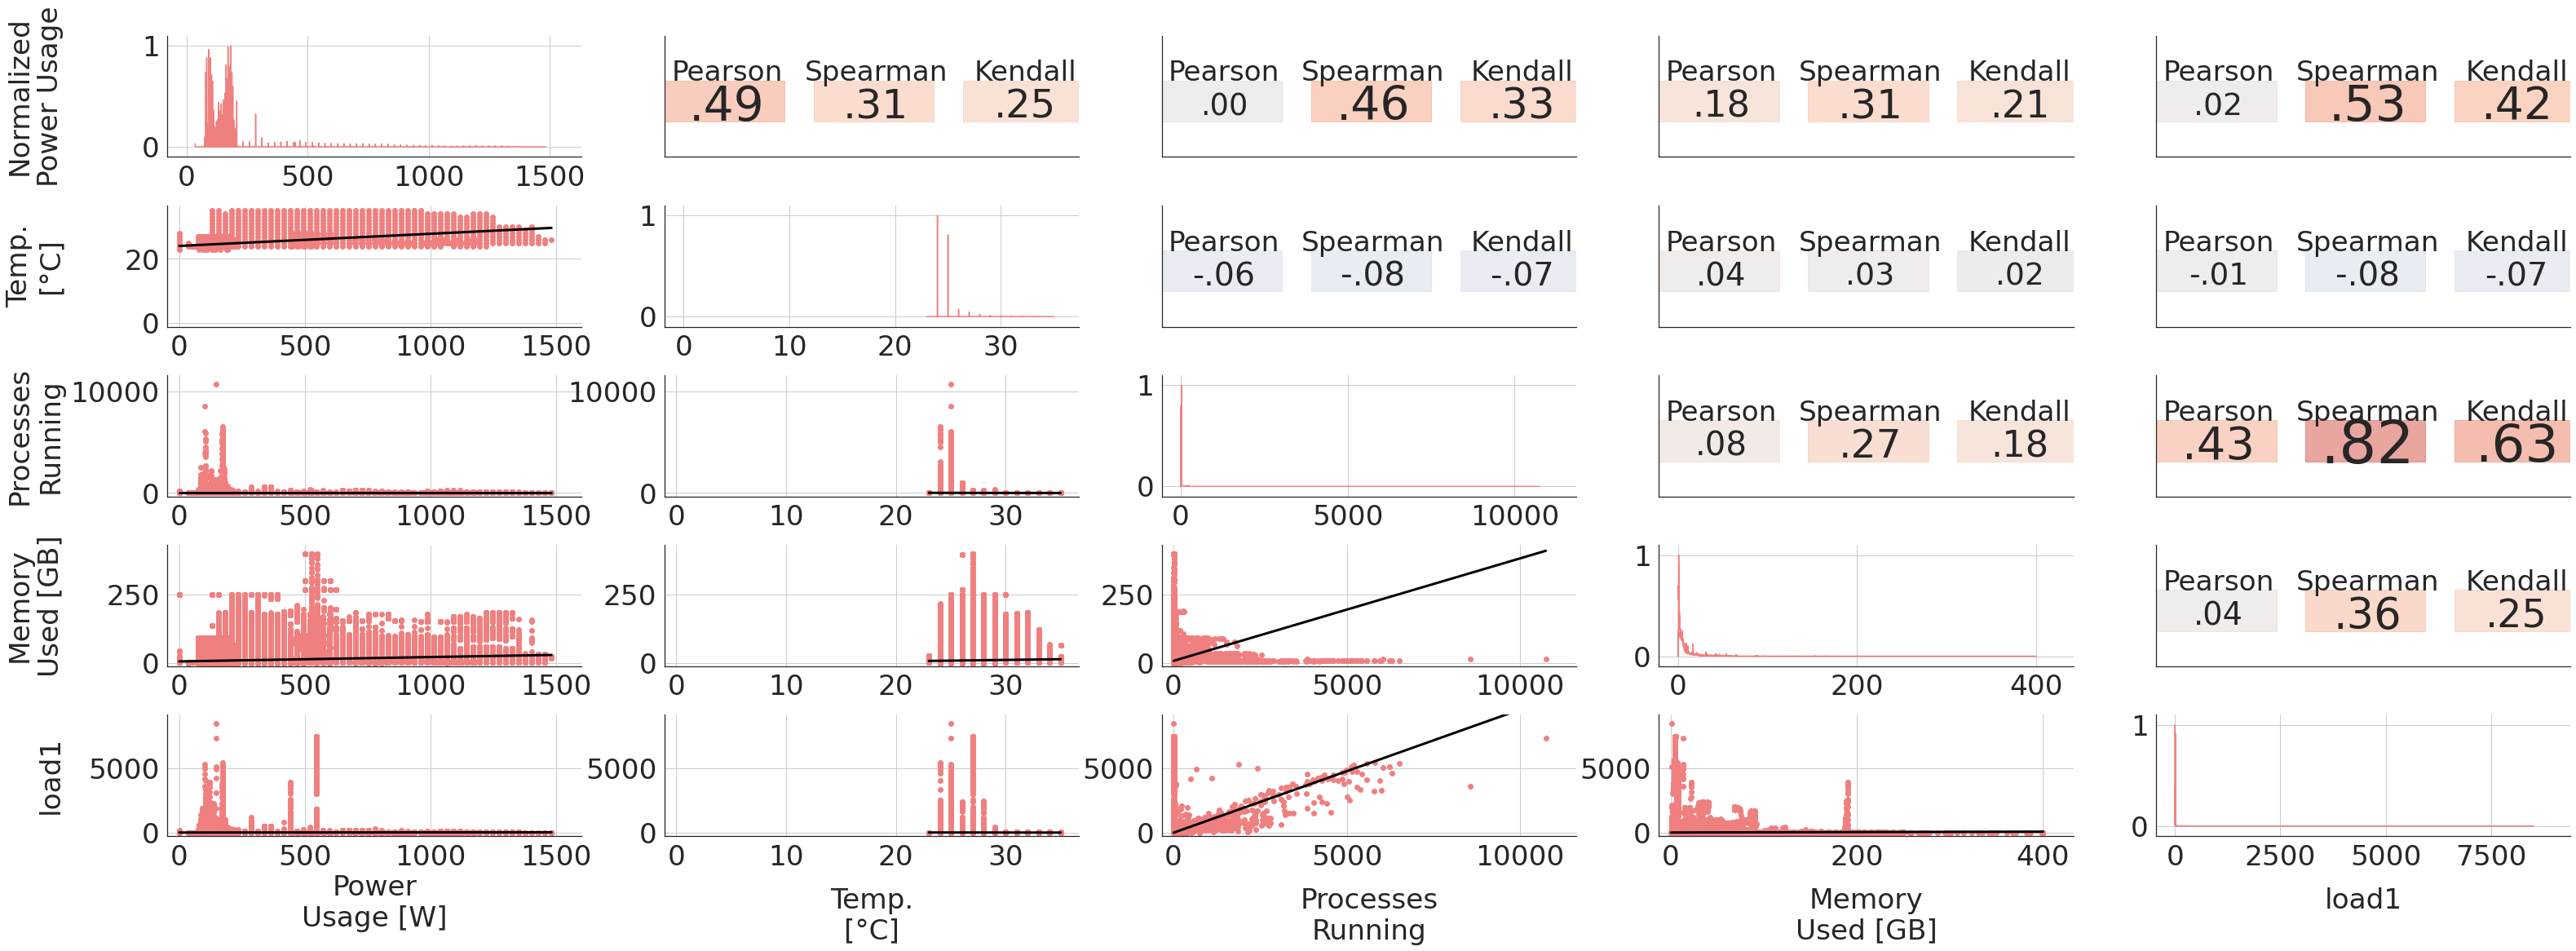

In [10]:
cache_file = "./koalas_correlation_plot_joined_df"
value_names = [
        'power_usage',
        'temperature',
        'processes_running',
        'memory_used',
        'load1',
    ]

def corrdot(ax, x_series, y_series, **kwargs):
    # Check if we have cached the result prior, because computing the correlation is a heavy operation.
    coef_file = "./cache/{}_{}_correlations.csv".format(y_series, x_series)
    if not os.path.exists(coef_file):
        print("Computing correlations for " + coef_file)
        df = pd.read_parquet(cache_file,
                             columns=[x_series, y_series],
                             engine='pyarrow'
                             )

        values = [scipy.stats.pearsonr(df[x_series], df[y_series]),
                        scipy.stats.spearmanr(df[x_series], df[y_series]),
                        scipy.stats.kendalltau(df[x_series], df[y_series]),
                        ]

        correlations = [val[0] for val in values]
        pvalues = [val[1] for val in values]

        del df
        with open(coef_file, "w") as file1:
            file1.write("|".join([str(x) for x in correlations]))
            file1.write("\n")
            file1.write("|".join([str(x) for x in pvalues]))
    else:
        with open(coef_file, "r") as file1:
            correlations = [float(x) for x in file1.readline().split("|")]

    # Plot the correlations using a scatterplot
    correlation_names = ["Pearson", "Spearman", "Kendall"]
    x = list(range(1, len(correlations) + 1))
    y = [.5] * len(correlations)

    step = 0.72 / float(2 * len(correlations) - 2)
    x_fraction = 0.15

    # Get a colormap for the inverval -1,1 as this is the min/max of the correlation values
    cmap = plt.cm.get_cmap('coolwarm')
    cNorm = plt.cm.colors.Normalize(vmin=-1, vmax=1)
    scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=cmap)

    for index, corr_r in enumerate(correlations):
        font_size = abs(corr_r) * 18 + 15
        corr_text = f"{corr_r:2.2f}".replace("0.", ".")

        # Create a background rectangle to depict the color intensity of the correlation
        # As it's a patch, it's based on the percentage location in the plot.
        rgba = scalarMap.to_rgba(corr_r)

        # As we cannot use ax.transAxes with Rectangle, compute the bounds :(
        y_start, y_end = ax.get_ylim()
        x_start, x_end = ax.get_xlim()

        rect_x = (x_fraction - .15) * (x_end - x_start)
        rect_y = (y[index] - .21) * (y_end - y_start)
        rect_width = 0.29 * (x_end - x_start)
        rect_height = 0.34 * (y_end - y_start)

        rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height,
                             fill=True, color=rgba, alpha=0.5, zorder=0)
        ax.add_patch(rect)

        # Show the type of correlation and its value.
        # Make sure to use "axes fraction" so this code always work even when the axes range other than 0-1.
        ax.text(x_fraction, y[index] + .3, correlation_names[index], ha='center', va='top', fontsize=14 * font_size_factor,
                transform=ax.transAxes)
        ax.text(x_fraction, y[index] -.09, corr_text, ha='center', va='center', transform=ax.transAxes, fontsize=font_size * font_size_factor)
        x_fraction = x_fraction + step

        # Add a visual devider between the groups
        if index < len(correlations) - 1:
            # ax.annotate("|", (x_fraction, y[index]), ha='center', va='center', xycoords="axes fraction", fontsize=25, color="lightgrey")
            x_fraction = x_fraction + step


def scatter_reg(ax, x_series, y_series, **kwargs):
    kwargs['color'] = "lightcoral"
    
    plot_cache = os.path.join("./cache", f"correlation_plot_scatter_reg_scatter_{y_series}_{x_series}.npy")
    
    if not os.path.exists(plot_cache):
        print("computing " + plot_cache)
        df = pd.read_parquet(cache_file,
                         columns=[x_series, y_series],
                         engine='pyarrow'
                         ).dropna()

        # Grab the actual data.
        x_series = df[x_series]
        y_series = df[y_series]

        df = df.groupby([x_series, y_series]).size().reset_index().rename(columns={0: 'count'})
        
        x_vals = df[x_series]
        y_vals = df[y_series]
        del df
        with open(plot_cache, 'wb') as plot_cache_file:
            np.save(plot_cache_file, x_vals)
            np.save(plot_cache_file, y_vals)
    else:
        with open(plot_cache, 'rb') as plot_cache_file:
            x_vals = np.load(plot_cache_file)
            y_vals = np.load(plot_cache_file)

    #         ax.scatter(df[x_series.name], df[y_series.name], df['count'])
    ax.scatter(x_vals, y_vals, rasterized=True, **kwargs)

    ax.set_xlim(0)
    ax.set_ylim(0)

    # We then plot the regression line
    # Note: this probably can be computed using Dask arrays and apply_along_axis. Future work.
    plot_cache = os.path.join("./cache", f"correlation_plot_scatter_reg_plot_{y_series}_{x_series}.npy")
    
    if not os.path.exists(plot_cache):
        print("computing " + plot_cache)
        x_vals = np.unique(x_series)
        y_vals = np.poly1d(np.polyfit(x_series, y_series, 1))(x_vals)
        with open(plot_cache, 'wb') as plot_cache_file:
            np.save(plot_cache_file, x_vals)
            np.save(plot_cache_file, y_vals)
    else:
        with open(plot_cache, 'rb') as plot_cache_file:
            x_vals = np.load(plot_cache_file)
            y_vals = np.load(plot_cache_file)
    kwargs['color'] = "black"
    ax.plot(x_vals, y_vals, linewidth=3, rasterized=True, **kwargs)
    
    ax.set_ylim(-.03 * ax.get_ylim()[1], ax.get_ylim()[1] * 1.03)
    ax.set_xlim(-.03 * ax.get_xlim()[1], ax.get_xlim()[1] * 1.03)


    del x_vals
    del y_vals
    del x_series
    del y_series

    
def run_pdf(ax, series, **kwargs):
    kwargs['color'] = "lightcoral"
    
    plot_cache = os.path.join("./cache", f"correlation_plot_norm_cdf_plot_{series}.npy")
    if not os.path.exists(plot_cache):
        df = pd.read_parquet(cache_file,
                                 columns=[series],
                                 engine='pyarrow'
                                 ).reset_index(drop=True)

        series = df[series]
        series = series[series > 0]

        histogram, bins = np.histogram(series, bins='auto', density=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        histogram = histogram / histogram.max()

        with open(plot_cache, 'wb') as plot_cache_file:
                np.save(plot_cache_file, bin_centers)
                np.save(plot_cache_file, histogram)
    else:
        with open(plot_cache, 'rb') as plot_cache_file:
            bin_centers = np.load(plot_cache_file)
            histogram = np.load(plot_cache_file)
                
    ax.plot(bin_centers, histogram, rasterized=True, **kwargs)
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-.05 * ax.get_xlim()[1], ax.get_xlim()[1] * 1.05)
    

plot_labels = {
    'power_usage': "Power Usage [W]",
    'temperature': "Temperature [" + u"\u00b0" + "C]",
    'processes_running': "Processes\nRunning",
    'memory_used': "Memory Used [GB]",
    'load1': "load1",
}

columns = list(dd.read_parquet(cache_file, engine='pyarrow').columns)
col_indices = list(range(len(columns)))
fake_df = pd.DataFrame([col_indices], columns=columns, dtype=np.int64)

fig, axes = plt.subplots(5, 5, figsize=(44,16))

plot_label_list = [
    "Power\nUsage [W]",
    "Temp.\n[" + u"\u00b0" + "C]", 
    "Processes\nRunning", 
    "Memory\nUsed [GB]", 
    "load1",
]

font_size_factor = 2.45
# Set the correct labels
for i in range(5):
    for j in range(5):
        if i == j:
            run_pdf(axes[i, j], value_names[i])
        elif i < j:
            corrdot(axes[i, j], value_names[i], value_names[j])
        else:
            scatter_reg(axes[i, j], value_names[i], value_names[j])
        
        xlabel = axes[i, j].get_xlabel()
        ylabel = axes[i, j].get_ylabel()
        axes[i, j].tick_params(axis='both', which='major', labelsize=14 * font_size_factor)
        axes[i, j].tick_params(axis='both', which='minor', labelsize=14 * font_size_factor)
        axes[i, j].grid(True)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
            
        # Left-most axes, the first column
        if j == 0:
            axes[i, j].set_ylabel(plot_label_list[i], fontsize=14 * font_size_factor)
            # Align the labels on the yaxis
            axes[i, j].yaxis.set_label_coords(-.25, 0.5)
            if i == 4:
                axes[i, j].set_xlabel(plot_label_list[j], fontsize=14 * font_size_factor)
            if i == 0:
                axes[i, j].set_ylabel("Normalized\nPower Usage", fontsize=14 * font_size_factor)
        elif i == 4:
            axes[i, j].set_xlabel(plot_label_list[j], fontsize=14 * font_size_factor, labelpad=20)

        elif i != j:
            axes[i, j].set_xlabel("")
            axes[i, j].set_ylabel("")
            if i < j:
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

print("Writing plot to file.")
# a pdf would be 400-500mb at least, use png.
fig.savefig("pearson_correlation_plot_{}_{}.png".format("-".join(value_names), date_time), bbox_inches = 'tight')
fig.savefig("pearson_correlation_plot_{}.pdf".format("-".join(value_names)), bbox_inches = 'tight')
print("done")

In [ ]:
fig.savefig("pearson_correlation_plot_{}_{}.png".format("-".join(value_names), date_time))
fig.savefig("pearson_correlation_plot_{}_{}.pdf".format("-".join(value_names), date_time))